# TCA  (Tranfert componant analysis)

In [4]:
## Ipython magic commands...! 

%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [1]:
### All the packages we need:
from Traj_creator import Traj_data
from TCA import *
from Mitocheck_Read import MitoCheck_Read
from Randomforest import RandomForest_Autotunner,plot_matrix,Measure,check_rotate

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import cPickle as pkl

# $X_S$

In [2]:
## Well name

if os.path.isfile("H2B_N_F_0.csv"):
    print "The file existed so I loaded it."
    H2B_N_F_0 = Traj_data(file_name="H2B_N_F_0.csv",pkl_traj_file="./Pkl_file") 
    H2B_N_F_0.caract="Normalized by dividing by first element"

else:    
    H2B_N_F_0=Traj_data()#(pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

    H2B_N_F_0.extracting(num_str,"both_channels_0015.hdf5",'primary') 
    ## Extracting the hdf5 file for the primary channel (H2b)
    
#    H2B_N_.add_error() ## We had it so that the data won't have to do 0/0

    H2B_N_F_0.Add_traj(normalize=True,all_traj=False,average=False,diff=False)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    H2B_N_F_0.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    H2B_N_F_0.renaming_and_merge() 
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.

    H2B_N_F_0.data.to_csv('H2B_N_F_0.csv',index=False,header=True)

    

if H2B_N_F_0.Var_missing[0] in H2B_N_F_0.train.columns:
    H2B_N_F_0.missing_features_train()
if H2B_N_F_0.Var_missing[0] in H2B_N_F_0.data.columns:
    H2B_N_F_0.missing_features_data()

        
X_S=H2B_N_F_0.train.ix[pd.notnull(H2B_N_F_0.train['traj']),H2B_N_F_0.names+["Type"]]


X_S.dropna(axis=0)
Y_S=X_S["Type"]
X_S=X_S[H2B_N_F_0.names]

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


/home/pubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# $X_T$

In [5]:
MitoCheck = MitoCheck_Read()
MitoCheck.Normalize(division=True,average=False)  

if MitoCheck.Var_missing[0] in MitoCheck.data.columns:
    MitoCheck.missing_features()

X_T=MitoCheck.data[MitoCheck.names]

aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  74on well 315
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  90on well 315
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  151on well 315
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  156on well 315
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  439on well 315
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  152on well 074
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: N

MitoCheck_Read()
Updated member Group_of_traj
Because of missing values I adjusted it, in the case X_t/X_0


aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  46on well 352
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  49on well 352
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  62on well 352
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))


# Getting matrix W

## Rescaling the data

As we are going to be using a kernel trick we have to normalize the data, in particular as we are interested in differences in distributions it is interesting to set the data as it will have 0 mean and variance 1.

In particular: $$X'_S=\frac{X_S-\bar{X_S}}{\sqrt{V(X_S)}}$$ 

And : $$X'_T=\frac{X_T-\bar{X_T}}{\sqrt{V(X_T)}}$$

In [10]:
## We get ride of features where their variance is 0
Std_X_S=np.std(X_S,axis=0)
print "number of features in the data before: %d" %(X_S.shape[1])
new_names_X_S=[el for el in X_S.columns if np.std(X_S[el])!=0]
new_names_X_T=[el for el in X_T.columns if np.std(X_T[el])!=0]
if new_names_X_S==new_names_X_T:
    new_names = new_names_X_T  
else:
    new_names = list(set(new_names_X_S).intersection(new_names_X_T))
X_S=X_S[new_names]
X_T=X_T[new_names]
print "number of features in the data after : %d" %(X_S.shape[1])

# variable granu_open_area_5 is having difficulties as the mean of granu_open_area_5 is inf,
# so infinite values have to be removed, ask Thomas about it
n_orig=X_T.shape[0]

X_T=X_T.replace([np.inf, -np.inf], np.nan)
X_T=X_T.dropna(axis=0, how='any')

mean_X_S=np.mean(X_S,axis=0)
Std_X_S =np.std(X_S,axis=0)

mean_X_T=np.mean(X_T,axis=0)
Std_X_T =np.std(X_T,axis=0)

X_S=X_S.apply(lambda x: (x-mean_X_S)/Std_X_S,axis=1)
X_T=X_T.apply(lambda x: (x-mean_X_T)/Std_X_T,axis=1)

#Taking inf values and missing values

X_T=X_T.dropna(axis=0, how='any')
n_late=X_T.shape[0]
print "number of instances in the data before: %d" %(n_orig)
print "number of instances in the data after : %d" %(n_late)

number of features in the data before: 235
number of features in the data after : 233
number of instances in the data before: 18594
number of instances in the data after : 18539


[  1.75538271e+04  -9.22845266e+02   1.06631119e+01]
14.6177664708


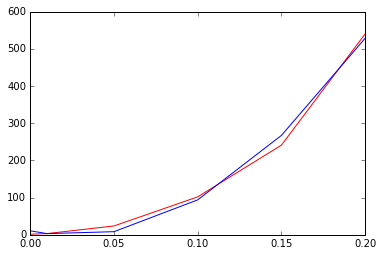

In [31]:
x=[0,0.01,0.05,0.1,0.15,0.2]
y=[1.53,3.29,23.8,102,241,540]
deg=2
t=np.polyfit(x, y, deg) 
def f(x):
    return(t[0]*x*x+t[1]*x+t[2])
y_false=[f(x[i]) for i in range(len(y))]
print t
plt.plot(x,y,'-r')
plt.plot(x,y_false,'-b')
print f(0.25)/60

In [30]:

m    =233  # dimension of the new feature space
mu   =0.1  # weigth scalar to tune (maybe)
gamma=10   # hyper parameter for the gaussian kernel
p    =2    # p norm used to calculate the distances between samples
random_sample_T=0.25
# Fraction of the task domain to use

%time W_eigenValues,W_eigenVectors,K,data_used=TCA(X_S,X_T,m,mu,gamma,p,random_sample_T)

4634 samples taken from the task domain
CPU times: user 16min 24s, sys: 3min 9s, total: 19min 34s
Wall time: 5min 33s


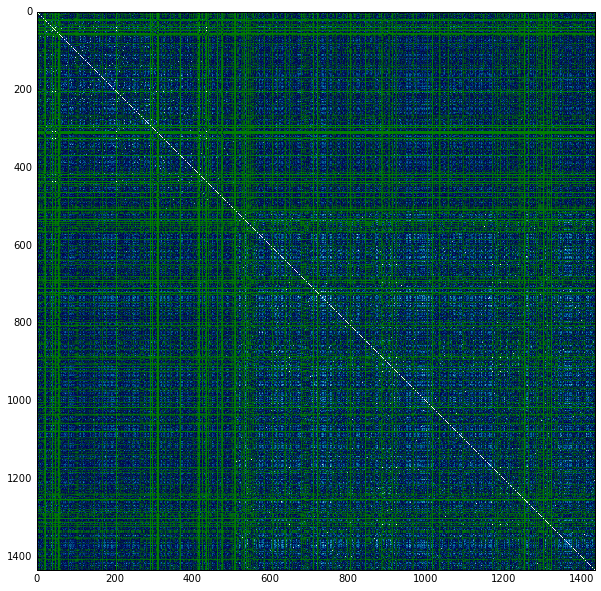

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 #plot size

K=np.array(K)
fig = plt.figure()
plt.imshow(K, interpolation='nearest', cmap=plt.cm.ocean)
plt.axis([0, K.shape[0] , K.shape[1], 0])
plt.pcolor(K, cmap=plt.cm.ocean, vmin=0, vmax=1) 
plt.show()      


In [32]:
## Because of the inversion problem we have a null imaginary part, just to be sure it
## doesn't mess anything up in the next part...
W_eigenVectors=sp.real(W_eigenVectors)

training=(sp.mat(W_eigenVectors.T)*sp.mat(K)).T[0:508]
train=pd.DataFrame(training)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,223,224,225,226,227,228,229,230,231,232
0,26.787803,2.381649,4.005206,1.434197,-1.606483,-0.189607,0.662608,0.068154,0.275313,-0.166558,...,-0.036925,-0.003025,-0.001704,0.000236,0.012172,-0.034858,-0.012418,0.040601,0.028656,0.009564
1,15.011272,3.984315,6.152308,1.295147,-0.168506,-0.798831,0.159208,0.240578,1.691754,-0.215133,...,-0.008602,-0.006706,0.002146,0.000793,0.003476,-0.042088,-0.024383,-0.012482,-0.015677,0.018154
2,0.037104,0.213205,0.116243,0.113618,-0.115765,-0.089423,-0.045195,-0.098518,-0.025007,-0.001264,...,-0.001840,-0.000573,-0.000614,-0.000180,0.002058,0.016872,0.003324,-0.003476,0.002380,-0.003594
3,26.213561,1.257868,4.538095,-0.729987,-1.486998,0.273213,-0.724926,-0.489154,0.209206,0.087617,...,-0.034147,-0.018531,-0.000249,0.000478,0.014735,-0.002343,0.008750,-0.001149,0.056978,-0.009044
4,17.602156,-1.297944,6.334163,1.016360,0.410356,1.084839,-1.638498,0.549778,0.992834,0.318373,...,0.051295,0.036210,-0.004022,-0.001626,-0.035759,-0.025355,-0.000324,0.033589,0.026638,-0.014813


Processing time: 10.503099 in sec


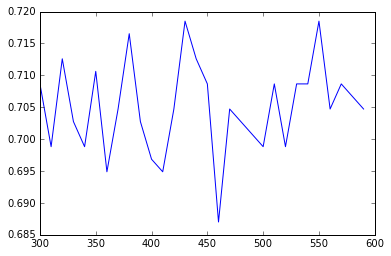

In [33]:
## Results for m=40

kfold=10
values=[300 + i*10 for i in range(30)]

model=RandomForest_Autotunner(values,n_jobs=2)

model.tunning(train,Y_S,kfold,plot=True,fit_new_model=True,opti=True) #to get cm
plt.show()

In [18]:
X_T.shape


(18539, 233)

In [21]:
execfile('TCA.py')

new_Data=getting_kernel_projection(X_T.ix[X_T.index[0:5],X_T.columns],pd.DataFrame(data_used),m,W_eigenVectors,gamma=1,p=2)

> /home/pubuntu/Documents/InternWork2/TCA.py(145)getting_kernel_projection()
-> data[new_feat]=data.apply(lambda x: new_feature(data_used,W_eigenVectors,x,gamma,p,names),axis=1)
(Pdb) 
(Pdb) c
> /home/pubuntu/Documents/InternWork2/TCA.py(136)new_feature()
-> return(sp.array(new_feat).flatten())
(Pdb) c
> /home/pubuntu/Documents/InternWork2/TCA.py(136)new_feature()
-> return(sp.array(new_feat).flatten())
(Pdb) c
> /home/pubuntu/Documents/InternWork2/TCA.py(136)new_feature()
-> return(sp.array(new_feat).flatten())
(Pdb) c
> /home/pubuntu/Documents/InternWork2/TCA.py(136)new_feature()
-> return(sp.array(new_feat).flatten())
(Pdb) c
> /home/pubuntu/Documents/InternWork2/TCA.py(136)new_feature()
-> return(sp.array(new_feat).flatten())
(Pdb) c
> /home/pubuntu/Documents/InternWork2/TCA.py(136)new_feature()
-> return(sp.array(new_feat).flatten())
(Pdb) c


In [25]:
new_Data[["TCA_" + str(i) for i in range(m)]]

,TCA_0,TCA_1,TCA_2,TCA_3,TCA_4,TCA_5,TCA_6,TCA_7,TCA_8,TCA_9,...,TCA_223,TCA_224,TCA_225,TCA_226,TCA_227,TCA_228,TCA_229,TCA_230,TCA_231,TCA_232
12891,6.070924e-02,-8.088289e-01,5.944455e-01,-7.483552e-01,-6.764521e-01,3.806877e-01,-1.608289e+00,-1.159173e+00,-4.577374e-01,6.852741e-01,...,1.004896e-01,2.434011e-02,-1.170546e-01,9.029052e-02,-5.391289e-02,-1.142885e-01,6.440656e-02,1.977071e-02,-7.697855e-02,1.688618e-01
12895,-1.784551e-10,-9.853722e-10,1.159555e-09,-6.284935e-10,-5.827589e-11,-1.017176e-12,-8.656931e-10,-6.737108e-10,1.661057e-11,1.025803e-09,...,5.176606e-10,6.034342e-10,3.838188e-10,-1.240595e-09,-2.128250e-10,-3.896487e-10,1.423844e-10,1.834737e-10,-7.400606e-10,1.754254e-10
12901,-1.031123e-12,-5.281467e-12,6.081904e-12,-3.115829e-12,-5.384992e-13,-8.151312e-14,-4.518351e-12,-3.262294e-12,1.854322e-13,5.011862e-12,...,2.122834e-12,2.445979e-12,2.279695e-12,-5.253165e-12,-1.108408e-12,-2.174581e-12,5.132080e-13,1.095690e-12,-3.067735e-12,4.271436e-13
12909,-4.981775e-14,-4.262647e-13,4.068192e-13,-2.898774e-13,-1.533373e-13,1.062929e-13,-4.176722e-13,-3.138754e-13,-4.150973e-14,3.301870e-13,...,1.832326e-13,7.698756e-14,-8.346330e-14,-8.327258e-14,-2.471488e-14,-7.768636e-14,1.069014e-14,2.945758e-14,-1.293928e-13,2.435282e-14
12921,-2.898484e-13,-1.728301e-12,1.974996e-12,-1.079234e-12,-1.491087e-13,1.257735e-13,-1.519544e-12,-1.199215e-12,-4.101184e-14,1.802126e-12,...,1.103421e-12,1.079861e-12,3.958611e-13,-1.927207e-12,-2.684614e-13,-6.990460e-13,3.595173e-13,2.560766e-13,-1.427353e-12,3.497862e-13


In [33]:
print sum(X_T.>10000000000000)
print X_T.shape

27028
(18502, 233)


Processing time: 2.427693 in sec


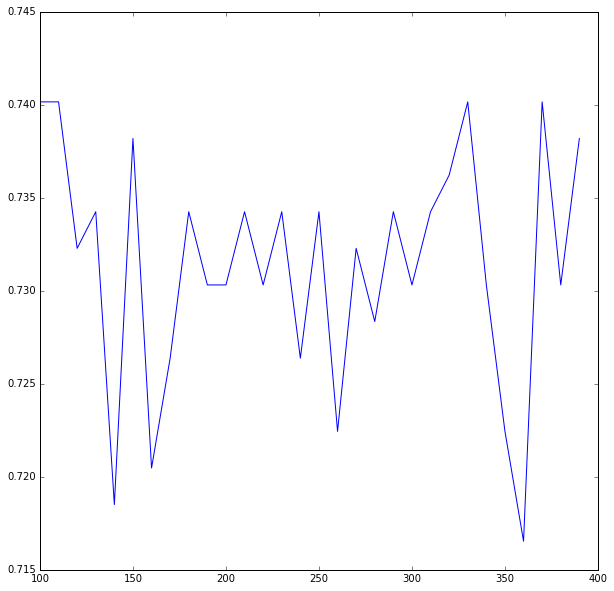

In [19]:
## Results for m=30
m_bis=30

kfold=10
values=[100 + i*10 for i in range(30)]

model=RandomForest_Autotunner(values,n_jobs=7)

model.tunning(train.ix[:,0:m_bis],Y_S,kfold,plot=True,fit_new_model=True,opti=True) #to get cm
plt.show()

Processing time: 3.648226 in sec


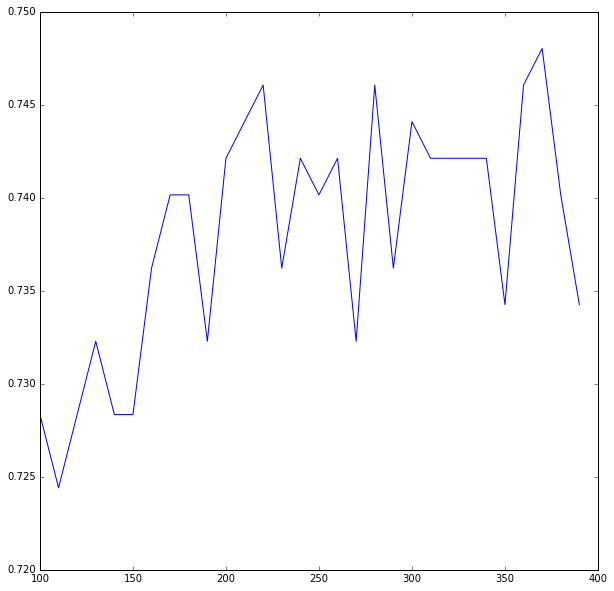

In [20]:
## Results for m=20
m_bis=20

kfold=10
values=[100 + i*10 for i in range(30)]

model=RandomForest_Autotunner(values,n_jobs=7)

model.tunning(train.ix[:,0:m_bis],Y_S,kfold,plot=True,fit_new_model=True,opti=True) #to get cm
plt.show()

Processing time: 2.821912 in sec


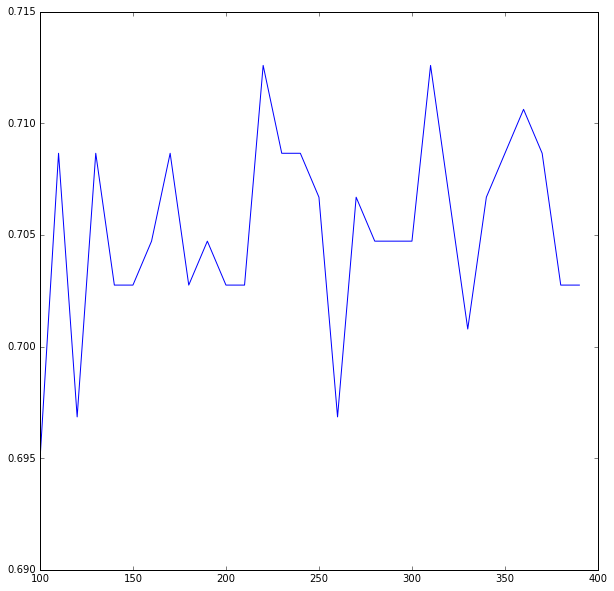

In [21]:
## Results for m=30
m_bis=10

kfold=10
values=[100 + i*10 for i in range(30)]

model=RandomForest_Autotunner(values,n_jobs=7)

model.tunning(train.ix[:,0:m_bis],Y_S,kfold,plot=True,fit_new_model=True,opti=True) #to get cm
plt.show()